# Yield curve in the Mehra&ndash;Prescott economy

For this problem, we extend the codes from the main analysis of the Mehra&ndash;Prescott model.

To quickly review, Mehra and Prescott (1985) proposed an economy with underlying uncertainty
described by a two-state Markov chain $x_{t}$ with transition matrix

\begin{equation*}
\mathbf{P}=\left[
\begin{array}{cc}
\phi  & 1-\phi  \\
1-\phi  & \phi
\end{array}%
\right] .
\end{equation*}

Consumption growth is modeled as a stationary process

\begin{equation*}
\frac{C_{t+1}}{C_{t}}=\exp \left( g_{C}\left( x_{t},x_{t+1}\right) \right)
\end{equation*}

represented by the matrix $\Gamma _{C}$ with elements

\begin{equation*}
\left[ \Gamma _{C}\right] _{ij}=\exp \left( g_{C}\left(
x_{t}=e_{i},x_{t+1}=e_{j}\right) \right) .
\end{equation*}

Preferences are of the CRRA\ form with time preference $\beta $ and relative
risk aversion $\gamma $, implying the SDF of the form

\begin{equation*}
\frac{S_{t+1}}{S_{t}}=\beta \left( \frac{C_{t+1}}{C_{t}}\right) ^{-\gamma
}=\beta \exp \left( -\gamma g_{C}\left( x_{t},x_{t+1}\right) \right)
\end{equation*}

represented by the matrix $\Gamma _{S}$ with elements

\begin{equation*}
\left[ \Gamma _{S}\right] _{ij}=\beta \exp \left( -\gamma g_{C}\left(
x_{t}=e_{i},x_{t+1}=e_{j}\right) \right) =\beta \left[ \Gamma _{C}\right]
_{ij}^{-\gamma }
\end{equation*}

where the $-\gamma $ power applies elementwise.

Mehra and Precott (1985) assume that the consumption growth matrix is given by

\begin{equation*}
\Gamma _{C}=\left[
\begin{array}{cc}
1+\mu +\delta  & 1+\mu -\delta  \\
1+\mu +\delta  & 1+\mu -\delta
\end{array}%
\right]
\end{equation*}

so that state $e_{1}$ is the high-growth state, state $e_{2}$ is the
low-growth state.

## Bond prices and the yield curve

A zero-coupon risk-free bond is an asset that pays one unit of the numeraire (consumption, dollars) at a pre-specified date. We can therefore denote the price of a bond that is just about to mature in the current period $t$ as

$$Q^{[0]}_t = 1.$$

The superindex $[0]$ denotes time to maturity. Then we can apply the recursive valuation formula: if we have the time $t+1$ price of a bond that has $T-1$ remaining period until maturity, denoted $Q^{[T-1]}_{t+1}$, then we can compute the time-$t$ price as

$$Q_t^{[T]} = E_t \left[ \frac{S_{t+1}}{S_t} Q_{t+1}^{[T-1]} \right].$$

Notice the notation $Q_t^{[T]}$, since in period $t$, the bond has $T$ periods until maturity.

The <b>yield</b> (or yield to maturity) on this bond is the average (per period) return investor earns between today and the maturity of the bond. This yield is safe because the terminal payoff at maturity is fixed. From this definition, the yield is

$$y_t^{[T]} = \frac{1}{T} \log \frac{1}{Q_t^{[T]}} = -\frac{1}{T} \log Q_t^{[T]}.$$

The yield on the one-period bond (bond with maturity equal to one period) is the risk-free rate.

## Matrix implementation

Since the state follows an $n$-state Markov chain, stationary functions of the state $x_t$ can be represented as vectors of length $n$. We can therefore encode the price of a bond with maturity $T$ using a state-dependent price vector $\mathbf{q}^{[T]}$ with entries

\begin{equation*}
\mathbf{q}^{[T]}_{i}=Q^{[T]}\left( x_{t}=e_{i}\right) .
\end{equation*}

Using the matrix structure, the recursive valuation equation can be expressed as

\begin{equation*}
\mathbf{q}^{[T]}_{i}=q\left( x_{t}=e_{i}\right) =\sum_{j=1}^{n}%
\left[ \mathbf{P}\right] _{ij}\left[ \Gamma _{S}\right] _{ij} \mathbf{q}^{[T-1]}_{j}.
\end{equation*}

This can be written in compact form as

\begin{equation*}
\mathbf{q}^{[T]}=\left( \mathbf{P}\ast \Gamma _{S}\right)
 \mathbf{q}^{[T-1]}
\end{equation*}

where $\ast$ is the symbol for elementwise multiplication and $\mathbf{1}$ is a vector of ones.

Consequently, the yield for the bond with maturity $T$ is given by

$$\mathbf{y}^{[T]} = -\frac{1}{T}\log \mathbf{q}^{[T]}.$$

Plotting the yield curve in a particular state $x_t = e_i$ corresponds to plotting $\mathbf{y}^{[T]}_i$ as a function of $T$ for the selected range of horizons.

## Numerical implementation

The numerical implementation extends the function <b>solve_Mehra_Prescott</b>.

Define the local folder where graphs will be stored, and from which data will be retrieved. If you are running the notebook within Google Colab, use the second option.

In [1]:
graphfolder = "graphs/"
datafolder = "data/"

# options for Google Colab (uncomment the following lines)
# graphfolder = "gdrive/MyDrive/graphs/"
# datafolder = "gdrive/MyDrive/data/"

Import relevant packages.

In [2]:
# render graphs within notebook
%matplotlib inline

# import packages
import numpy as np

# load econutil package with some frequently used functions
import econutil as ec

Root package econutil imported.


Function that solves for asset pricing moments in the Mehra-Prescott economy.

In [3]:
def solve_Mehra_Prescott(model):
    
    S = model["SDF"]
    P = model["P"]
    GAMMAG = model["GAMMAG"]
    
    N = P.shape[0]
    I = np.asmatrix(np.identity(N))
    one = np.asmatrix(np.ones([N,1]))
    
    # first compute the unconditional stationary distribution PII (assuming it is unique)
    # unconditional stationary distribution is the eigenvector of P' associated
    # with eigenvalue equal to 1 (the largest eigenvalue)
    eigval,eigvec = np.linalg.eig(P.transpose())
    idx = np.abs(eigval).argsort()
    eigval = eigval[idx]
    eigvec = eigvec[:,idx]
    PII = eigvec[:,-1] /sum( eigvec[:,-1])

    # conditional gross risk-free rate (Nx1 vector)
    Rf = 1 / (np.multiply(P,S)*one)
    # unconditional gross risk-free rate
    ERf = Rf.transpose()*PII
    
    # recursive formula for the price-dividend ratio: q =  P.*S.*G * (q + 1)
    # solution given by
    # q = inv(I - P.*S.*G) * (P.*S.*G)*1 = (I - P.*S.*G) \ (P.*S.*G)*1
    # the .* operator is the elementwise multiplication, 1 is an Nx1 vector of ones

    # solution for the infinite-horizon asset only valid
    # if P.*S.*G has eigenvalues inside the unit circle
    M = np.multiply(np.multiply(P,S),GAMMAG)
    eigval,eigvec = np.linalg.eig(M)
    maxeig = max(eigval)

    if (maxeig < 1):
        # asset price (Nx1 vector)
        q = np.linalg.inv(I - M) * (M*one)
        # returns (NxN matrix of returns R(i,j)
        R = np.multiply(np.multiply(np.tile(q.transpose(),[N,1]) + 1, 1 / np.tile(q,[1,N])),GAMMAG);
        # conditional expected returns (Nx1 vector)
        EtR = np.asmatrix(np.diag(R * P.transpose())).transpose()
        # unconditional expected return
        ER = EtR.transpose()*PII
        # excess returns, realized and expected
        Re = R - np.tile(Rf,[1,N]);
        EtRe = EtR - Rf;
        ERe = ER - ERf;
    else:
        q = np.asmatrix(np.empty([N,1]))*np.nan
        R = np.asmatrix(np.empty([N,N]))*np.nan
        EtR = np.asmatrix(np.empty([N,1]))*np.nan
        ER = np.nan;
        Re = np.asmatrix(np.empty([N,N]))*np.nan
        EtRe = np.asmatrix(np.empty([N,1]))*np.nan
        ERe = np.nan;
        
    # compute the yield curve
    capT = 100
    y = np.asmatrix(np.zeros([N,capT]))
    q = np.asmatrix(np.ones([N,1]))
    for T in range(capT):
        q = np.multiply(P,S)*q
        y[:,T] = -1/(T+1)*np.log(q)

    sol = {"PII": PII, "Rf": Rf, "ERf": ERf, "q": q, "R": R, "EtR": EtR, "ER": ER, "Re": Re, "EtRe": EtRe, "ERe": ERe, "y": y}
    return sol

Solve a list of economies.

In [4]:
# model specification
model = {"PHI": 0.43, "MU": 0.018, "DELTA": 0.036}

model["P"] = np.asmatrix([[model["PHI"], 1-model["PHI"]], [1-model["PHI"], model["PHI"]]])
model["GAMMAC"] = np.asmatrix([[1+model["MU"]+model["DELTA"],1+model["MU"]-model["DELTA"]], [1+model["MU"]+model["DELTA"],1+model["MU"]-model["DELTA"]]])
model["GAMMAG"] = model["GAMMAC"].copy()

# define a list of economies via combinations of parameters [BETA, GAMMA]
model_vec = [[0.99, 2], [0.96, 2], [0.99, 4]]
yield_curves = [0] * 3

for i,m in enumerate(model_vec):
    model["BETA"] = m[0]
    model["GAMMA"] = m[1]
    model["SDF"] = model["BETA"] * np.power(model["GAMMAC"],-model["GAMMA"])
    sol = solve_Mehra_Prescott(model)
    yield_curves[i] = sol["y"]

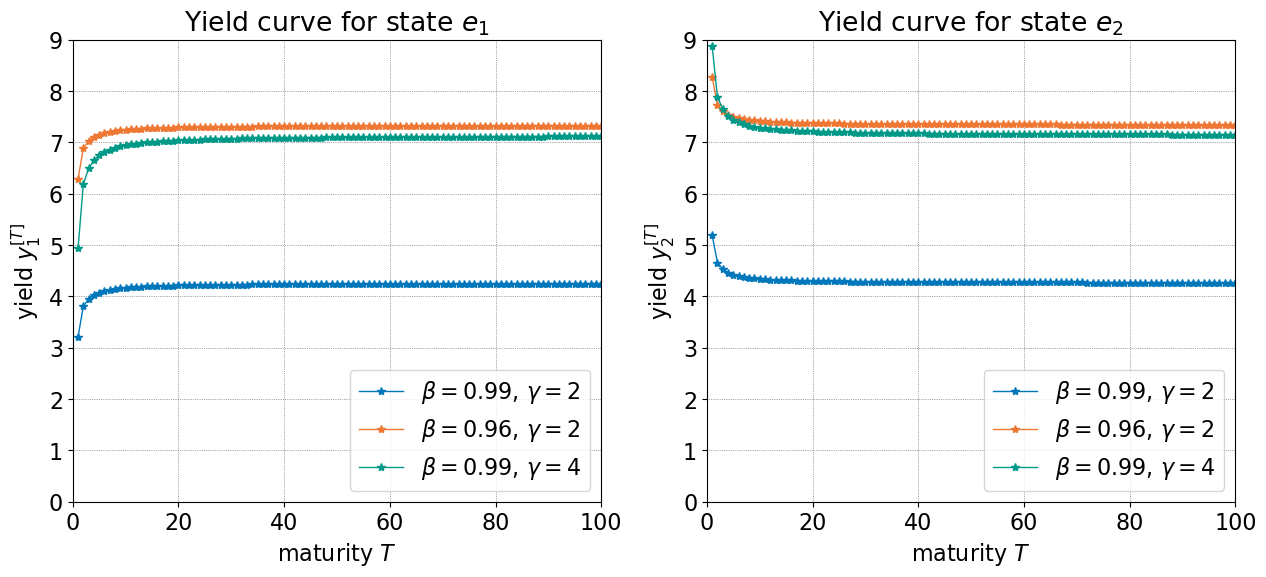

In [6]:
# display yield curve results
capT = yield_curves[0].shape[1]

param = {'figsize' : [15,6], 'fontsize': 16, 'subplots': [1,2],
         'title': '',
         'xlim': [0,capT], 'ylim': [0,9],
         'xlabel': 'maturity $T$', 'ylabel': 'yield $y^{[T]}_1$',
         'ylogscale': False,
         'showgrid': True, 'highlightzero': False,
         'showNBERrecessions' : False, 'showNBERrecessions_y': [0,7]}

fig,ax = ec.GenerateTSPlot(param)

ax[0,0].plot(np.linspace(1,capT,capT),np.squeeze(np.asarray(yield_curves[0][0,:]))*100,linewidth=1,marker='*',color=ec.tolColor['tolVibrantBlue'],linestyle='solid',label='$\\beta = ' + str(model_vec[0][0]) + '$, $\\gamma = ' + str(model_vec[0][1]) + ' $');
ax[0,0].plot(np.linspace(1,capT,capT),np.squeeze(np.asarray(yield_curves[1][0,:]))*100,linewidth=1,marker='*',color=ec.tolColor['tolVibrantOrange'],linestyle='solid',label='$\\beta = ' + str(model_vec[1][0]) + '$, $\\gamma = ' + str(model_vec[1][1]) + ' $');
ax[0,0].plot(np.linspace(1,capT,capT),np.squeeze(np.asarray(yield_curves[2][0,:]))*100,linewidth=1,marker='*',color=ec.tolColor['tolVibrantTeal'],linestyle='solid',label='$\\beta = ' + str(model_vec[2][0]) + '$, $\\gamma = ' + str(model_vec[2][1]) + ' $');

ax[0,0].set_title('Yield curve for state $e_1$')
x = ax[0,0].legend(loc="lower right")

ax[0,1].plot(np.linspace(1,capT,capT),np.squeeze(np.asarray(yield_curves[0][1,:]))*100,linewidth=1,marker='*',color=ec.tolColor['tolVibrantBlue'],linestyle='solid',label='$\\beta = ' + str(model_vec[0][0]) + '$, $\\gamma = ' + str(model_vec[0][1]) + ' $');
ax[0,1].plot(np.linspace(1,capT,capT),np.squeeze(np.asarray(yield_curves[1][1,:]))*100,linewidth=1,marker='*',color=ec.tolColor['tolVibrantOrange'],linestyle='solid',label='$\\beta = ' + str(model_vec[1][0]) + '$, $\\gamma = ' + str(model_vec[1][1]) + ' $');
ax[0,1].plot(np.linspace(1,capT,capT),np.squeeze(np.asarray(yield_curves[2][1,:]))*100,linewidth=1,marker='*',color=ec.tolColor['tolVibrantTeal'],linestyle='solid',label='$\\beta = ' + str(model_vec[2][0]) + '$, $\\gamma = ' + str(model_vec[2][1]) + ' $');

ax[0,1].set_title('Yield curve for state $e_2$')
ax[0,1].set_ylabel('yield $y^{[T]}_2$')
x = ax[0,1].legend(loc="lower right")

fig.set_facecolor('#FFFFFF')
fig.savefig('graphs/asset_pricing_mehra_prescott_yield_curves.pdf',bbox_inches='tight')

The left panel depicts the yield curves in alternative economies for state $x_t = e_1$ (state that predicts that low growth is more likely going into the next period, because $\phi<0.5$, while the right panel shows yield curves for state $x_t = e_2$. Same colors depict the yield curves in the same economy.

To understand the shapes of the curves, we have to understand that interest rates are determined by three forces:

* <b>Time preference</b>: The higher the impatience, the higher must be the interest rates to compensate investors for saving

* <b>Elasticity of substitution over time</b>: Investors dislike imbalanced consumption over time and want to smooth it out. When the economy is growing more (or agents have lower elasticity of substitution), agents want to borrow more to be able to consume more today, paying off the debt by sacrificing consumption in the future. To disincentivize this, interest rates must be higher.

* <b>Risk aversion</b>: Risk-free bonds are a safe asset, so when the economy is riskier or agents more risk averse, these safe assets are more attractive, and interest rates must decrease in equilibrium to disincentivize this saving.

First, focus on the baseline economy ($\beta=0.99$, $\gamma =2$, blue lines). When growth is expected to be low (left panel), shorter-maturity interest rates are lower than when growth is expected to be high (right panel). This is in line with the elasticity of substitution effect. When growth is expected to be high, agents want to borrow more, and to disincentivize this (in order to clear the market for the risk-free asset), interest rates must be higher to make borrowing more costly.

Also notice, that while short-maturity yields fluctuate across states, long-maturity yields do not. This is a reflection of the stationarity of the economy. Over longer horizons, expected growth rate is independent on the current state.

Second, the orange lines depict the effect of increasing the impatience (a decrease in $\beta$ relative to the benchmark economy). More impatient agents would like to borrow more, so to disincentivize this in equilibrium, interest rates must increase.

Third, the green lines (relative to blue lines) represent the effect of increasing the risk aversion parameter $\gamma$. However, one has to understand that an increase in $\gamma$ has two effects: it increases risk aversion but also decreases willingness to substitute intertemporally.

The increase in risk aversion makes safe assets more attractive, which will decrease interest rates in equilibrium. The decrease in intertemporal elasticity of substitution makes agents want to borrow more, which increases interest rates in equilibrium. The latter effect dominates, so interest rates increase.

There is one more notable observation to make. The Mehra and Prescott (1985) economy suffers from risk premia that are too low relatively to empirically observed values. These risk premia can increase by increasing $\gamma$ substantially, however, we observed that this increases the risk-free rate way too much. The graph above shows another undesirable efffect of increasing risk aversion: the volatility of short-run rates (the difference in the short run rate between state $e_1$ and state $e_2$ increases substantially. However, we know that empirically, interest rates are rather smooth. So increasing risk aversion creates another puzzle: some of the models that attempt to fit risk premia generate volatility of risk-free rates that are at odds with data.